### CNN-LSTM for 55 analytes dataset
### Author: Edgar Acuna
### Created: July 27, 2021
### Reviewed July 2, 2023

In [89]:
# cnn lstm model
from numpy import mean
from numpy import std, unique
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from matplotlib import pyplot
 
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None)
    return dataframe.values

In [90]:
 # load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [91]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Subs/'
    # print(filepath)
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['X_'+group+'.csv']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.csv')
    return X, y

In [92]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    print(prefix)
    trainX, trainy = load_dataset_group('train', prefix + 'datasets/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'datasets/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy.astype(int)-1
    testy = testy.astype(int)-1
    #For PCA
    #trainy = trainy.astype(int)-1
    #testy = testy.astype(int)-1
    print(unique(testy))
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [93]:
# define model
import time
verbose, epochs, batch_size = 1, 40, 256
 # load data
trainX, trainy, testX, testy = load_dataset()
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 9, 189
#For PCA
#n_steps, n_length = 5, 20
print(trainX.shape)
trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
#print("number of features",n_features)
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(300, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.summary()
start_time=time.time()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
baseline_history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
# evaluate model
test_results= model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
#print(test_results)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
print("Training time:---  %s seconds ---" % (time.time() - start_time))


(20256, 1701, 1) (20256, 1)
(5064, 1701, 1) (5064, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54]
(20256, 1701, 1) (20256, 55) (5064, 1701, 1) (5064, 55)
(20256, 1701, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_56 (TimeDi  (None, None, 187, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, None, 93, 32)     0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, None, 93, 32)     0         
 stributed)                                                      
                     

64/64 [==============================] - 46s 718ms/step - loss: 0.1947 - accuracy: 0.9368 - val_loss: 0.4233 - val_accuracy: 0.8919
Epoch 40/40
20/20 [==============================] - 3s 137ms/step - loss: 0.4103 - accuracy: 0.8910
Test results - Loss: 0.41027572751045227 - Accuracy: 0.8909952640533447%
Training time:---  1482.786908864975 seconds ---


In [94]:
#Function for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

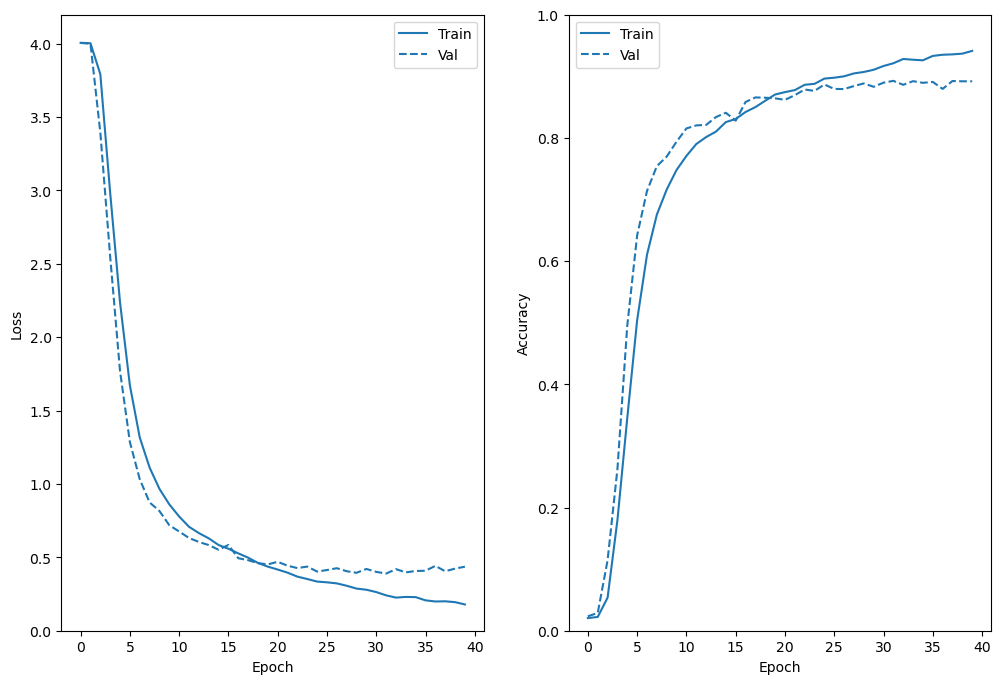

In [95]:
plot_metrics(baseline_history)

In [96]:
#Computing F1-score
import numpy as np
import sklearn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, roc_auc_score
train_features = np.array(trainX)
test_features = np.array(testX)
train_labels=np.array(trainy)
#train_labels=pd.DataFrame(trainy)
#n_values = train_labels.idxmax(axis=1)
y_values=np.argmax(train_labels,axis=1)
#print(y_values)
test_labels=np.array(testy)
yt_values=np.argmax(test_labels,axis=1)
#train_predictions_baseline = model.predict_classes(train_features, batch_size=150)
a=model.predict([test_features])
predict_classes=np.argmax(a,axis=1)
#prob2=pd.DataFrame(model.predict_proba(test_features,batch_size=150))
#a=prob2.max(axis=1)
#print('Probability of classification',(a[a>.80].shape[0])/prob2.shape[0])
print('Rate of Probability of classification exceding a trhershold',(a[a>.50].shape[0])/a.shape[0])
a1=model.predict([train_features])
predict_classes1=np.argmax(a1,axis=1)
#f1_train=sklearn.metrics.f1_score(ytrain, train_predictions_baseline, average="weighted")
#test_predictions_baseline = model.predict_classes(test_features, batch_size=150)
#print(test_predictions_baseline)
#f1_test=sklearn.metrics.f1_score(test_labels, test_predictions_baseline, average="weighted")
#print('f1_scores in testing set',f1_test)
#Calculating metrics for each class
print("EVALUATION ON TESTING DATA")
print(classification_report(yt_values, predict_classes))

159/159 [==============================] - 6s 34ms/step
Rate of Probability of classification exceding a trhershold 0.9374012638230648
633/633 [==============================] - 23s 37ms/step
EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       100
           1       0.74      0.91      0.82        88
           2       1.00      0.93      0.96        85
           3       0.88      0.84      0.86        89
           4       0.96      0.89      0.92        73
           5       0.92      0.97      0.95        89
           6       0.83      0.94      0.88        90
           7       0.99      0.84      0.91        97
           8       0.92      0.97      0.94        92
           9       0.92      0.93      0.92       120
          10       0.86      0.92      0.89        84
          11       0.90      0.94      0.92       110
          12       0.77      0.83      0.80        90
          13       0.95 

In [97]:
cm=confusion_matrix(yt_values, predict_classes)
#print(cm)
good=np.diag(cm)/np.unique(yt_values,return_counts=True)[1]
print(good)

[0.93       0.90909091 0.92941176 0.84269663 0.89041096 0.96629213
 0.94444444 0.83505155 0.9673913  0.925      0.91666667 0.93636364
 0.83333333 0.85714286 0.81578947 0.86021505 0.92857143 0.88172043
 0.9009901  0.90816327 0.89189189 0.90909091 0.84415584 0.94827586
 0.83168317 0.84615385 0.79069767 0.85454545 0.88571429 0.84042553
 0.83505155 0.97142857 0.88297872 0.88505747 0.94680851 0.92079208
 0.87179487 0.96       0.73148148 0.85333333 0.93406593 0.91208791
 0.95180723 0.9        0.95604396 0.93203883 0.84536082 0.79661017
 0.92307692 0.8952381  0.95402299 0.93877551 0.88636364 0.85526316
 0.76829268]


In [98]:
### bad analytes:  

ROC AUC score: 0.9438011225297662


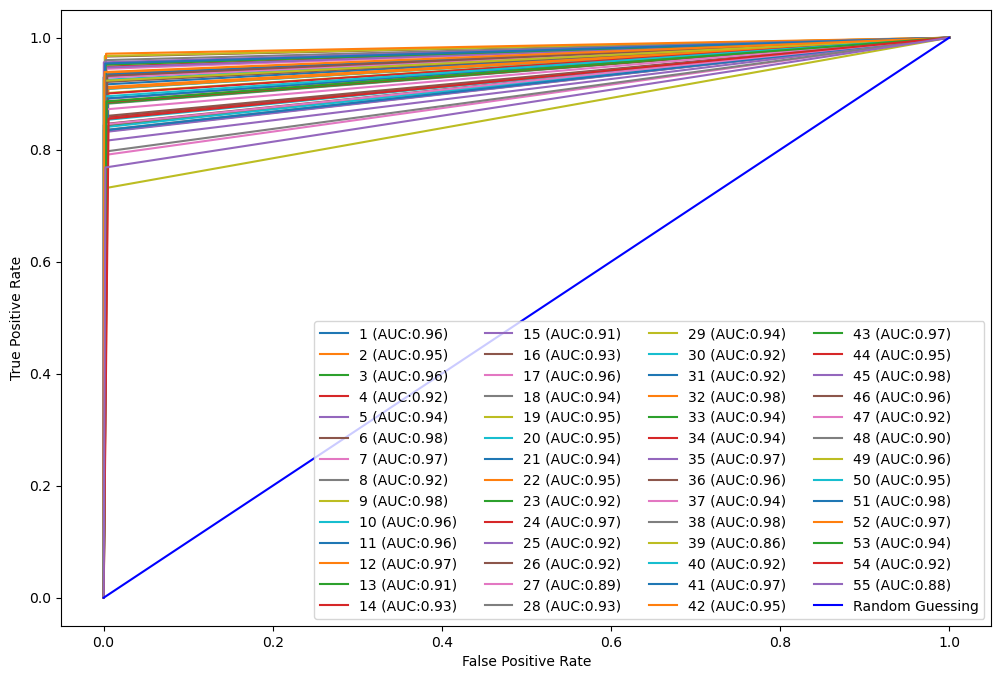

In [99]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= range(55)

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label+1, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(yt_values, predict_classes))

c_ax.legend(loc=4,ncol=4,fontsize=10)
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()